In [ ]:
!pip install blobfile
!pip install mpi4py

In [2]:
import os
import math
import enum
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import inspect
import argparse
import blobfile as bf
from mpi4py import MPI
import torch as th
import torch.distributed as dist
from torch.nn.parallel.distributed import DistributedDataParallel as DDP
import copy
import functools
import random

import dist_util, logger

In [3]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

In [4]:
def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [5]:
class ModelMeanType(enum.Enum):
    """
    Which type of output the model predicts.
    """

    PREVIOUS_X = enum.auto()  # the model predicts x_{t-1}
    START_X = enum.auto()  # the model predicts x_0
    EPSILON = enum.auto()  # the model predicts epsilon

In [6]:
class ModelVarType(enum.Enum):
    """
    What is used as the model's output variance.
    The LEARNED_RANGE option has been added to allow the model to predict
    values between FIXED_SMALL and FIXED_LARGE, making its job easier.
    """

    LEARNED = enum.auto()
    FIXED_SMALL = enum.auto()
    FIXED_LARGE = enum.auto()
    LEARNED_RANGE = enum.auto()

In [7]:
class LossType(enum.Enum):
    MSE = enum.auto()  # use raw MSE loss (and KL when learning variances)
    RESCALED_MSE = (
        enum.auto()
    )  # use raw MSE loss (with RESCALED_KL when learning variances)
    KL = enum.auto()  # use the variational lower-bound
    RESCALED_KL = enum.auto()  # like KL, but rescale to estimate the full VLB

    def is_vb(self):
        return self == LossType.KL or self == LossType.RESCALED_KL

In [8]:
class GaussianDiffusion:
    """
    Utilities for training and sampling diffusion models.

    Ported directly from here, and then adapted over time to further experimentation.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L42

    :param betas: a 1-D numpy array of betas for each diffusion timestep,
                  starting at T and going to 1.
    :param model_mean_type: a ModelMeanType determining what the model outputs.
    :param model_var_type: a ModelVarType determining how variance is output.
    :param loss_type: a LossType determining the loss function to use.
    :param rescale_timesteps: if True, pass floating point timesteps into the
                              model so that they are always scaled like in the
                              original paper (0 to 1000).
    """

    def __init__(
        self,
        *,
        betas,
        model_mean_type,
        model_var_type,
        loss_type,
        rescale_timesteps=False,
    ):
        self.model_mean_type = model_mean_type
        self.model_var_type = model_var_type
        self.loss_type = loss_type
        self.rescale_timesteps = rescale_timesteps

        # Use float64 for accuracy.
        betas = np.array(betas, dtype=np.float64)
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas
        self.alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain.
        self.posterior_log_variance_clipped = np.log(
            np.append(self.posterior_variance[1], self.posterior_variance[1:])
        )
        self.posterior_mean_coef1 = (
            betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * np.sqrt(alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).

        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = (
            _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        )
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = _extract_into_tensor(
            self.log_one_minus_alphas_cumprod, t, x_start.shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.

        In other words, sample from q(x_t | x_0).

        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        if noise is None:
            noise = th.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        assert x_start.shape == x_t.shape
        posterior_mean = (
            _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        assert (
            posterior_mean.shape[0]
            == posterior_variance.shape[0]
            == posterior_log_variance_clipped.shape[0]
            == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(
        self, model, x, t, clip_denoised=True, denoised_fn=None, model_kwargs=None
    ):
        """
        Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
        the initial x, x_0.

        :param model: the model, which takes a signal and a batch of timesteps
                      as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample. Applies before
            clip_denoised.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict with the following keys:
                 - 'mean': the model mean output.
                 - 'variance': the model variance output.
                 - 'log_variance': the log of 'variance'.
                 - 'pred_xstart': the prediction for x_0.
        """
        if model_kwargs is None:
            model_kwargs = {}

        B, C = x.shape[:2]
        assert t.shape == (B,)
        model_output = model(x, self._scale_timesteps(t), **model_kwargs)

        if self.model_var_type in [ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE]:
            assert model_output.shape == (B, C * 2, *x.shape[2:])
            model_output, model_var_values = th.split(model_output, C, dim=1)
            if self.model_var_type == ModelVarType.LEARNED:
                model_log_variance = model_var_values
                model_variance = th.exp(model_log_variance)
            else:
                min_log = _extract_into_tensor(
                    self.posterior_log_variance_clipped, t, x.shape
                )
                max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
                # The model_var_values is [-1, 1] for [min_var, max_var].
                frac = (model_var_values + 1) / 2
                model_log_variance = frac * max_log + (1 - frac) * min_log
                model_variance = th.exp(model_log_variance)
        else:
            model_variance, model_log_variance = {
                # for fixedlarge, we set the initial (log-)variance like so
                # to get a better decoder log likelihood.
                ModelVarType.FIXED_LARGE: (
                    np.append(self.posterior_variance[1], self.betas[1:]),
                    np.log(np.append(self.posterior_variance[1], self.betas[1:])),
                ),
                ModelVarType.FIXED_SMALL: (
                    self.posterior_variance,
                    self.posterior_log_variance_clipped,
                ),
            }[self.model_var_type]
            model_variance = _extract_into_tensor(model_variance, t, x.shape)
            model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        def process_xstart(x):
            if denoised_fn is not None:
                x = denoised_fn(x)
            if clip_denoised:
                return x.clamp(-1, 1)
            return x

        if self.model_mean_type == ModelMeanType.PREVIOUS_X:
            pred_xstart = process_xstart(
                self._predict_xstart_from_xprev(x_t=x, t=t, xprev=model_output)
            )
            model_mean = model_output
        elif self.model_mean_type in [ModelMeanType.START_X, ModelMeanType.EPSILON]:
            if self.model_mean_type == ModelMeanType.START_X:
                pred_xstart = process_xstart(model_output)
            else:
                pred_xstart = process_xstart(
                    self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
                )
            model_mean, _, _ = self.q_posterior_mean_variance(
                x_start=pred_xstart, x_t=x, t=t
            )
        else:
            raise NotImplementedError(self.model_mean_type)

        assert (
            model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        )
        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def _predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def _predict_xstart_from_xprev(self, x_t, t, xprev):
        assert x_t.shape == xprev.shape
        return (  # (xprev - coef2*x_t) / coef1
            _extract_into_tensor(1.0 / self.posterior_mean_coef1, t, x_t.shape) * xprev
            - _extract_into_tensor(
                self.posterior_mean_coef2 / self.posterior_mean_coef1, t, x_t.shape
            )
            * x_t
        )

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - pred_xstart
        ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def _scale_timesteps(self, t):
        if self.rescale_timesteps:
            return t.float() * (1000.0 / self.num_timesteps)
        return t

    def condition_mean(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
        """
        Compute the mean for the previous step, given a function cond_fn that
        computes the gradient of a conditional log probability with respect to
        x. In particular, cond_fn computes grad(log(p(y|x))), and we want to
        condition on y.

        This uses the conditioning strategy from Sohl-Dickstein et al. (2015).
        """
        gradient = cond_fn(x, self._scale_timesteps(t), **model_kwargs)
        new_mean = (
            p_mean_var["mean"].float() + p_mean_var["variance"] * gradient.float()
        )
        return new_mean

    def condition_score(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
        """
        Compute what the p_mean_variance output would have been, should the
        model's score function be conditioned by cond_fn.

        See condition_mean() for details on cond_fn.

        Unlike condition_mean(), this instead uses the conditioning strategy
        from Song et al (2020).
        """
        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)

        eps = self._predict_eps_from_xstart(x, t, p_mean_var["pred_xstart"])
        eps = eps - (1 - alpha_bar).sqrt() * cond_fn(
            x, self._scale_timesteps(t), **model_kwargs
        )

        out = p_mean_var.copy()
        out["pred_xstart"] = self._predict_xstart_from_eps(x, t, eps)
        out["mean"], _, _ = self.q_posterior_mean_variance(
            x_start=out["pred_xstart"], x_t=x, t=t
        )
        return out

    def p_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
    ):
        """
        Sample x_{t-1} from the model at the given timestep.

        :param model: the model to sample from.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict containing the following keys:
                 - 'sample': a random sample from the model.
                 - 'pred_xstart': a prediction of x_0.
        """
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        noise = th.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        if cond_fn is not None:
            out["mean"] = self.condition_mean(
                cond_fn, out, x, t, model_kwargs=model_kwargs
            )
        sample = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def p_sample_loop(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
    ):
        """
        Generate samples from the model.

        :param model: the model module.
        :param shape: the shape of the samples, (N, C, H, W).
        :param noise: if specified, the noise from the encoder to sample.
                      Should be of the same shape as `shape`.
        :param clip_denoised: if True, clip x_start predictions to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param device: if specified, the device to create the samples on.
                       If not specified, use a model parameter's device.
        :param progress: if True, show a tqdm progress bar.
        :return: a non-differentiable batch of samples.
        """
        final = None
        for sample in self.p_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
        ):
            final = sample
        return final["sample"]

    def p_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
    ):
        """
        Generate samples from the model and yield intermediate samples from
        each timestep of diffusion.

        Arguments are the same as p_sample_loop().
        Returns a generator over dicts, where each dict is the return value of
        p_sample().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            img = noise
        else:
            img = th.randn(*shape, device=device)
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            with th.no_grad():
                out = self.p_sample(
                    model,
                    img,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    cond_fn=cond_fn,
                    model_kwargs=model_kwargs,
                )
                yield out
                img = out["sample"]

# Note: DDIM is a method to make training diffusion models faster. It is, however, worse than GANs.
# https://arxiv.org/pdf/2105.05233.pdf
                
    def ddim_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        eta=0.0,
    ):
        """
        Sample x_{t-1} from the model using DDIM.

        Same usage as p_sample().
        """
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        if cond_fn is not None:
            out = self.condition_score(cond_fn, out, x, t, model_kwargs=model_kwargs)

        # Usually our model outputs epsilon, but we re-derive it
        # in case we used x_start or x_prev prediction.
        eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape)
        sigma = (
            eta
            * th.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * th.sqrt(1 - alpha_bar / alpha_bar_prev)
        )
        # Equation 12.
        noise = th.randn_like(x)
        mean_pred = (
            out["pred_xstart"] * th.sqrt(alpha_bar_prev)
            + th.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        )
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def ddim_reverse_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        model_kwargs=None,
        eta=0.0,
    ):
        """
        Sample x_{t+1} from the model using DDIM reverse ODE.
        """
        assert eta == 0.0, "Reverse ODE only for deterministic path"
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        # Usually our model outputs epsilon, but we re-derive it
        # in case we used x_start or x_prev prediction.
        eps = (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
            - out["pred_xstart"]
        ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
        alpha_bar_next = _extract_into_tensor(self.alphas_cumprod_next, t, x.shape)

        # Equation 12. reversed
        mean_pred = (
            out["pred_xstart"] * th.sqrt(alpha_bar_next)
            + th.sqrt(1 - alpha_bar_next) * eps
        )

        return {"sample": mean_pred, "pred_xstart": out["pred_xstart"]}

    def ddim_sample_loop(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
    ):
        """
        Generate samples from the model using DDIM.

        Same usage as p_sample_loop().
        """
        final = None
        for sample in self.ddim_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
            eta=eta,
        ):
            final = sample
        return final["sample"]

    def ddim_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
    ):
        """
        Use DDIM to sample from the model and yield intermediate samples from
        each timestep of DDIM.

        Same usage as p_sample_loop_progressive().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            img = noise
        else:
            img = th.randn(*shape, device=device)
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            with th.no_grad():
                out = self.ddim_sample(
                    model,
                    img,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    cond_fn=cond_fn,
                    model_kwargs=model_kwargs,
                    eta=eta,
                )
                yield out
                img = out["sample"]

    def _vb_terms_bpd(
        self, model, x_start, x_t, t, clip_denoised=True, model_kwargs=None
    ):
        """
        Get a term for the variational lower-bound.

        The resulting units are bits (rather than nats, as one might expect).
        This allows for comparison to other papers.

        :return: a dict with the following keys:
                 - 'output': a shape [N] tensor of NLLs or KLs.
                 - 'pred_xstart': the x_0 predictions.
        """
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(
            x_start=x_start, x_t=x_t, t=t
        )
        out = self.p_mean_variance(
            model, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
        )
        kl = normal_kl(
            true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
        )
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = th.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"]}

    def training_losses(self, model, x_start, t, model_kwargs=None, noise=None):
        """
        Compute training losses for a single timestep.

        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param t: a batch of timestep indices.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param noise: if specified, the specific Gaussian noise to try to remove.
        :return: a dict with the key "loss" containing a tensor of shape [N].
                 Some mean or variance settings may also have other keys.
        """
        if model_kwargs is None:
            model_kwargs = {}
        if noise is None:
            noise = th.randn_like(x_start)
        x_t = self.q_sample(x_start, t, noise=noise)

        terms = {}

        if self.loss_type == LossType.KL or self.loss_type == LossType.RESCALED_KL:
            terms["loss"] = self._vb_terms_bpd(
                model=model,
                x_start=x_start,
                x_t=x_t,
                t=t,
                clip_denoised=False,
                model_kwargs=model_kwargs,
            )["output"]
            if self.loss_type == LossType.RESCALED_KL:
                terms["loss"] *= self.num_timesteps
        elif self.loss_type == LossType.MSE or self.loss_type == LossType.RESCALED_MSE:
            model_output = model(x_t, self._scale_timesteps(t), **model_kwargs)

            if self.model_var_type in [
                ModelVarType.LEARNED,
                ModelVarType.LEARNED_RANGE,
            ]:
                B, C = x_t.shape[:2]
                assert model_output.shape == (B, C * 2, *x_t.shape[2:])
                model_output, model_var_values = th.split(model_output, C, dim=1)
                # Learn the variance using the variational bound, but don't let
                # it affect our mean prediction.
                frozen_out = th.cat([model_output.detach(), model_var_values], dim=1)
                terms["vb"] = self._vb_terms_bpd(
                    model=lambda *args, r=frozen_out: r,
                    x_start=x_start,
                    x_t=x_t,
                    t=t,
                    clip_denoised=False,
                )["output"]
                if self.loss_type == LossType.RESCALED_MSE:
                    # Divide by 1000 for equivalence with initial implementation.
                    # Without a factor of 1/1000, the VB term hurts the MSE term.
                    terms["vb"] *= self.num_timesteps / 1000.0

            target = {
                ModelMeanType.PREVIOUS_X: self.q_posterior_mean_variance(
                    x_start=x_start, x_t=x_t, t=t
                )[0],
                ModelMeanType.START_X: x_start,
                ModelMeanType.EPSILON: noise,
            }[self.model_mean_type]
            assert model_output.shape == target.shape == x_start.shape
            terms["mse"] = mean_flat((target - model_output) ** 2)
            if "vb" in terms:
                terms["loss"] = terms["mse"] + terms["vb"]
            else:
                terms["loss"] = terms["mse"]
        else:
            raise NotImplementedError(self.loss_type)

        return terms

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.

        This term can't be optimized, as it only depends on the encoder.

        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = th.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(
            mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0
        )
        return mean_flat(kl_prior) / np.log(2.0)

    def calc_bpd_loop(self, model, x_start, clip_denoised=True, model_kwargs=None):
        """
        Compute the entire variational lower-bound, measured in bits-per-dim,
        as well as other related quantities.

        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param clip_denoised: if True, clip denoised samples.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.

        :return: a dict containing the following keys:
                 - total_bpd: the total variational lower-bound, per batch element.
                 - prior_bpd: the prior term in the lower-bound.
                 - vb: an [N x T] tensor of terms in the lower-bound.
                 - xstart_mse: an [N x T] tensor of x_0 MSEs for each timestep.
                 - mse: an [N x T] tensor of epsilon MSEs for each timestep.
        """
        device = x_start.device
        batch_size = x_start.shape[0]

        vb = []
        xstart_mse = []
        mse = []
        for t in list(range(self.num_timesteps))[::-1]:
            t_batch = th.tensor([t] * batch_size, device=device)
            noise = th.randn_like(x_start)
            x_t = self.q_sample(x_start=x_start, t=t_batch, noise=noise)
            # Calculate VLB term at the current timestep
            with th.no_grad():
                out = self._vb_terms_bpd(
                    model,
                    x_start=x_start,
                    x_t=x_t,
                    t=t_batch,
                    clip_denoised=clip_denoised,
                    model_kwargs=model_kwargs,
                )
            vb.append(out["output"])
            xstart_mse.append(mean_flat((out["pred_xstart"] - x_start) ** 2))
            eps = self._predict_eps_from_xstart(x_t, t_batch, out["pred_xstart"])
            mse.append(mean_flat((eps - noise) ** 2))

        vb = th.stack(vb, dim=1)
        xstart_mse = th.stack(xstart_mse, dim=1)
        mse = th.stack(mse, dim=1)

        prior_bpd = self._prior_bpd(x_start)
        total_bpd = vb.sum(dim=1) + prior_bpd
        return {
            "total_bpd": total_bpd,
            "prior_bpd": prior_bpd,
            "vb": vb,
            "xstart_mse": xstart_mse,
            "mse": mse,
        }

In [9]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [10]:
def load_data(
    *,
    data_dir,
    batch_size,
    image_size,
    class_cond=False,
    deterministic=False,
    random_crop=False,
    random_flip=True,
    numpy=False,
):
    """
    For a dataset, create a generator over (images, kwargs) pairs.

    Each images is an NCHW float tensor, and the kwargs dict contains zero or
    more keys, each of which map to a batched Tensor of their own.
    The kwargs dict can be used for class labels, in which case the key is "y"
    and the values are integer tensors of class labels.

    :param data_dir: a dataset directory.
    :param batch_size: the batch size of each returned pair.
    :param image_size: the size to which images are resized.
    :param class_cond: if True, include a "y" key in returned dicts for class
                       label. If classes are not available and this is true, an
                       exception will be raised.
    :param deterministic: if True, yield results in a deterministic order.
    :param random_crop: if True, randomly crop the images for augmentation.
    :param random_flip: if True, randomly flip the images for augmentation.
    :param numpy: if True, uses a numpy array of images instead of the images itself
    (useful when storage is a luxury)
    """
    
    if numpy:
        dataset = np.load(data_dir)
    
    if not data_dir:
        raise ValueError("unspecified data directory")
    
    all_files = _list_image_files_recursively(data_dir, numpy)
    classes = None
    if class_cond:
        # Assume classes are the first part of the filename,
        # before an underscore.
        class_names = [bf.basename(path).split("_")[0] for path in all_files]
        sorted_classes = {x: i for i, x in enumerate(sorted(set(class_names)))}
        classes = [sorted_classes[x] for x in class_names]
    
    if not numpy:
        dataset = ImageDataset(
            image_size,
            all_files,
            classes=classes,
            shard=MPI.COMM_WORLD.Get_rank(),
            num_shards=MPI.COMM_WORLD.Get_size(),
            random_crop=random_crop,
            random_flip=random_flip,
        )
    ### Note: Pytorch's DataLoader? Pfffft! Might have to change this ###
    if deterministic:
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True
        )
        while True:
            yield from loader
    if not deterministic and not numpy:
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True
        )
        while True:
            yield from loader
    
    else:
        for i in range(0, len(dataset), batch_size):
            yield dataset[i:i+batch_size], {}


def _list_image_files_recursively(data_dir, numpy=False):
    if numpy:
        pass
    else:
        results = []
        for entry in sorted(bf.listdir(data_dir)):
            full_path = bf.join(data_dir, entry)
            ext = entry.split(".")[-1]
            if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
                results.append(full_path)
            elif bf.isdir(full_path):
                results.extend(_list_image_files_recursively(full_path))
        return results

In [11]:
class ImageDataset():
    def __init__(
        self,
        resolution,
        image_paths,
        classes=None,
        shard=0,
        num_shards=1,
        random_crop=False,
        random_flip=True,
    ):
        super().__init__()
        self.resolution = resolution
        self.local_images = image_paths[shard:][::num_shards]
        self.local_classes = None if classes is None else classes[shard:][::num_shards]
        self.random_crop = random_crop
        self.random_flip = random_flip

    def __len__(self):
        return len(self.local_images)

    def __getitem__(self, idx):
        path = self.local_images[idx]
        with bf.BlobFile(path, "rb") as f:
            pil_image = Image.open(f)
            pil_image.load()
        pil_image = pil_image.convert("RGB")

        if self.random_crop:
            arr = random_crop_arr(pil_image, self.resolution)
        else:
            arr = center_crop_arr(pil_image, self.resolution)

        if self.random_flip and random.random() < 0.5:
            arr = arr[:, ::-1]

        arr = arr.astype(np.float32) / 127.5 - 1

        out_dict = {}
        if self.local_classes is not None:
            out_dict["y"] = np.array(self.local_classes[idx], dtype=np.int64)
        return np.transpose(arr, [2, 0, 1]), out_dict


def center_crop_arr(pil_image, image_size):
    # We are not on a new enough PIL to support the `reducing_gap`
    # argument, which uses BOX downsampling at powers of two first.
    # Thus, we do it by hand to improve downsample quality.
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return arr[crop_y : crop_y + image_size, crop_x : crop_x + image_size]


def random_crop_arr(pil_image, image_size, min_crop_frac=0.8, max_crop_frac=1.0):
    min_smaller_dim_size = math.ceil(image_size / max_crop_frac)
    max_smaller_dim_size = math.ceil(image_size / min_crop_frac)
    smaller_dim_size = random.randrange(min_smaller_dim_size, max_smaller_dim_size + 1)

    # We are not on a new enough PIL to support the `reducing_gap`
    # argument, which uses BOX downsampling at powers of two first.
    # Thus, we do it by hand to improve downsample quality.
    while min(*pil_image.size) >= 2 * smaller_dim_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = smaller_dim_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = random.randrange(arr.shape[0] - image_size + 1)
    crop_x = random.randrange(arr.shape[1] - image_size + 1)
    return arr[crop_y : crop_y + image_size, crop_x : crop_x + image_size]

In [13]:
DEBUG = 10
INFO = 20
WARN = 30
ERROR = 40

DISABLED = 50


class KVWriter(object):
    def writekvs(self, kvs):
        raise NotImplementedError


class SeqWriter(object):
    def writeseq(self, seq):
        raise NotImplementedError


class HumanOutputFormat(KVWriter, SeqWriter):
    def __init__(self, filename_or_file):
        if isinstance(filename_or_file, str):
            self.file = open(filename_or_file, "wt")
            self.own_file = True
        else:
            assert hasattr(filename_or_file, "read"), (
                "expected file or str, got %s" % filename_or_file
            )
            self.file = filename_or_file
            self.own_file = False

In [14]:
class JSONOutputFormat(KVWriter):
    def __init__(self, filename):
        self.file = open(filename, "wt")

    def writekvs(self, kvs):
        for k, v in sorted(kvs.items()):
            if hasattr(v, "dtype"):
                kvs[k] = float(v)
        self.file.write(json.dumps(kvs) + "\n")
        self.file.flush()

    def close(self):
        self.file.close()

In [15]:
class CSVOutputFormat(KVWriter):
    def __init__(self, filename):
        self.file = open(filename, "w+t")
        self.keys = []
        self.sep = ","

    def writekvs(self, kvs):
        # Add our current row to the history
        extra_keys = list(kvs.keys() - self.keys)
        extra_keys.sort()
        if extra_keys:
            self.keys.extend(extra_keys)
            self.file.seek(0)
            lines = self.file.readlines()
            self.file.seek(0)
            for (i, k) in enumerate(self.keys):
                if i > 0:
                    self.file.write(",")
                self.file.write(k)
            self.file.write("\n")
            for line in lines[1:]:
                self.file.write(line[:-1])
                self.file.write(self.sep * len(extra_keys))
                self.file.write("\n")
        for (i, k) in enumerate(self.keys):
            if i > 0:
                self.file.write(",")
            v = kvs.get(k)
            if v is not None:
                self.file.write(str(v))
        self.file.write("\n")
        self.file.flush()

    def close(self):
        self.file.close()

In [16]:
class TensorBoardOutputFormat(KVWriter):
    """
    Dumps key/value pairs into TensorBoard's numeric format.
    """

    def __init__(self, dir):
        os.makedirs(dir, exist_ok=True)
        self.dir = dir
        self.step = 1
        prefix = "events"
        path = osp.join(osp.abspath(dir), prefix)
        import tensorflow as tf
        from tensorflow.python import pywrap_tensorflow
        from tensorflow.core.util import event_pb2
        from tensorflow.python.util import compat

        self.tf = tf
        self.event_pb2 = event_pb2
        self.pywrap_tensorflow = pywrap_tensorflow
        self.writer = pywrap_tensorflow.EventsWriter(compat.as_bytes(path))

    def writekvs(self, kvs):
        def summary_val(k, v):
            kwargs = {"tag": k, "simple_value": float(v)}
            return self.tf.Summary.Value(**kwargs)

        summary = self.tf.Summary(value=[summary_val(k, v) for k, v in kvs.items()])
        event = self.event_pb2.Event(wall_time=time.time(), summary=summary)
        event.step = (
            self.step
        )  # is there any reason why you'd want to specify the step?
        self.writer.WriteEvent(event)
        self.writer.Flush()
        self.step += 1

    def close(self):
        if self.writer:
            self.writer.Close()
            self.writer = None

In [17]:
def make_output_format(format, ev_dir, log_suffix=""):
    os.makedirs(ev_dir, exist_ok=True)
    if format == "stdout":
        return HumanOutputFormat(sys.stdout)
    elif format == "log":
        return HumanOutputFormat(osp.join(ev_dir, "log%s.txt" % log_suffix))
    elif format == "json":
        return JSONOutputFormat(osp.join(ev_dir, "progress%s.json" % log_suffix))
    elif format == "csv":
        return CSVOutputFormat(osp.join(ev_dir, "progress%s.csv" % log_suffix))
    elif format == "tensorboard":
        return TensorBoardOutputFormat(osp.join(ev_dir, "tb%s" % log_suffix))
    else:
        raise ValueError("Unknown format specified: %s" % (format,))

In [18]:
def logkv(key, val):
    """
    Log a value of some diagnostic
    Call this once for each diagnostic quantity, each iteration
    If called many times, last value will be used.
    """
    get_current().logkv(key, val)


def logkv_mean(key, val):
    """
    The same as logkv(), but if called many times, values averaged.
    """
    get_current().logkv_mean(key, val)


def logkvs(d):
    """
    Log a dictionary of key-value pairs
    """
    for (k, v) in d.items():
        logkv(k, v)


def dumpkvs():
    """
    Write all of the diagnostics from the current iteration
    """
    return get_current().dumpkvs()


def getkvs():
    return get_current().name2val


def log(*args, level=INFO):
    """
    Write the sequence of args, with no separators, to the console and output files (if you've configured an output file).
    """
    get_current().log(*args, level=level)


def debug(*args):
    log(*args, level=DEBUG)


def info(*args):
    log(*args, level=INFO)


def warn(*args):
    log(*args, level=WARN)


def error(*args):
    log(*args, level=ERROR)


def set_level(level):
    """
    Set logging threshold on current logger.
    """
    get_current().set_level(level)


def set_comm(comm):
    get_current().set_comm(comm)


def get_dir():
    """
    Get directory that log files are being written to.
    will be None if there is no output directory (i.e., if you didn't call start)
    """
    return get_current().get_dir()


record_tabular = logkv
dump_tabular = dumpkvs


def profile_kv(scopename):
    logkey = "wait_" + scopename
    tstart = time.time()
    try:
        yield
    finally:
        get_current().name2val[logkey] += time.time() - tstart


def profile(n):
    """
    Usage:
    @profile("my_func")
    def my_func(): code
    """

    def decorator_with_name(func):
        def func_wrapper(*args, **kwargs):
            with profile_kv(n):
                return func(*args, **kwargs)

        return func_wrapper

    return decorator_with_name

In [19]:
def get_current():
    if Logger.CURRENT is None:
        _configure_default_logger()

    return Logger.CURRENT


class Logger(object):
    DEFAULT = None  # A logger with no output files. (See right below class definition)
    # So that you can still log to the terminal without setting up any output files
    CURRENT = None  # Current logger being used by the free functions above

    def __init__(self, dir, output_formats, comm=None):
        self.name2val = defaultdict(float)  # values this iteration
        self.name2cnt = defaultdict(int)
        self.level = INFO
        self.dir = dir
        self.output_formats = output_formats
        self.comm = comm

    # Logging API, forwarded
    # ----------------------------------------
    def logkv(self, key, val):
        self.name2val[key] = val

    def logkv_mean(self, key, val):
        oldval, cnt = self.name2val[key], self.name2cnt[key]
        self.name2val[key] = oldval * cnt / (cnt + 1) + val / (cnt + 1)
        self.name2cnt[key] = cnt + 1

    def dumpkvs(self):
        if self.comm is None:
            d = self.name2val
        else:
            d = mpi_weighted_mean(
                self.comm,
                {
                    name: (val, self.name2cnt.get(name, 1))
                    for (name, val) in self.name2val.items()
                },
            )
            if self.comm.rank != 0:
                d["dummy"] = 1  # so we don't get a warning about empty dict
        out = d.copy()  # Return the dict for unit testing purposes
        for fmt in self.output_formats:
            if isinstance(fmt, KVWriter):
                fmt.writekvs(d)
        self.name2val.clear()
        self.name2cnt.clear()
        return out

    def log(self, *args, level=INFO):
        if self.level <= level:
            self._do_log(args)

    # Configuration
    # ----------------------------------------
    def set_level(self, level):
        self.level = level

    def set_comm(self, comm):
        self.comm = comm

    def get_dir(self):
        return self.dir

    def close(self):
        for fmt in self.output_formats:
            fmt.close()

    # Misc
    # ----------------------------------------
    def _do_log(self, args):
        for fmt in self.output_formats:
            if isinstance(fmt, SeqWriter):
                fmt.writeseq(map(str, args))


def get_rank_without_mpi_import():
    # check environment variables here instead of importing mpi4py
    # to avoid calling MPI_Init() when this module is imported
    for varname in ["PMI_RANK", "OMPI_COMM_WORLD_RANK"]:
        if varname in os.environ:
            return int(os.environ[varname])
    return 0


def mpi_weighted_mean(comm, local_name2valcount):
    """
    Copied from: https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/common/mpi_util.py#L110
    Perform a weighted average over dicts that are each on a different node
    Input: local_name2valcount: dict mapping key -> (value, count)
    Returns: key -> mean
    """
    all_name2valcount = comm.gather(local_name2valcount)
    if comm.rank == 0:
        name2sum = defaultdict(float)
        name2count = defaultdict(float)
        for n2vc in all_name2valcount:
            for (name, (val, count)) in n2vc.items():
                try:
                    val = float(val)
                except ValueError:
                    if comm.rank == 0:
                        warnings.warn(
                            "WARNING: tried to compute mean on non-float {}={}".format(
                                name, val
                            )
                        )
                else:
                    name2sum[name] += val * count
                    name2count[name] += count
        return {name: name2sum[name] / name2count[name] for name in name2sum}
    else:
        return {}


def configure(dir=None, format_strs=None, comm=None, log_suffix=""):
    """
    If comm is provided, average all numerical stats across that comm
    """
    if dir is None:
        dir = os.getenv("OPENAI_LOGDIR")
    if dir is None:
        dir = osp.join(
            tempfile.gettempdir(),
            datetime.datetime.now().strftime("openai-%Y-%m-%d-%H-%M-%S-%f"),
        )
    assert isinstance(dir, str)
    dir = os.path.expanduser(dir)
    os.makedirs(os.path.expanduser(dir), exist_ok=True)

    rank = get_rank_without_mpi_import()
    if rank > 0:
        log_suffix = log_suffix + "-rank%03i" % rank

    if format_strs is None:
        if rank == 0:
            format_strs = os.getenv("OPENAI_LOG_FORMAT", "stdout,log,csv").split(",")
        else:
            format_strs = os.getenv("OPENAI_LOG_FORMAT_MPI", "log").split(",")
    format_strs = filter(None, format_strs)
    output_formats = [make_output_format(f, dir, log_suffix) for f in format_strs]

    Logger.CURRENT = Logger(dir=dir, output_formats=output_formats, comm=comm)
    if output_formats:
        log("Logging to %s" % dir)


def _configure_default_logger():
    configure()
    Logger.DEFAULT = Logger.CURRENT


def reset():
    if Logger.CURRENT is not Logger.DEFAULT:
        Logger.CURRENT.close()
        Logger.CURRENT = Logger.DEFAULT
        log("Reset logger")


def scoped_configure(dir=None, format_strs=None, comm=None):
    prevlogger = Logger.CURRENT
    configure(dir=dir, format_strs=format_strs, comm=comm)
    try:
        yield
    finally:
        Logger.CURRENT.close()
        Logger.CURRENT = prevlogger

In [20]:
"""
Helpers for various likelihood-based losses. These are ported from the original
Ho et al. diffusion models codebase:
https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/utils.py
"""

def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.

    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, th.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for th.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.

    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs

In [21]:
"""
Various utilities for neural networks.
"""

# PyTorch 1.7 has SiLU, but we support PyTorch 1.5.
class SiLU(nn.Module):
    def forward(self, x):
        return x * th.sigmoid(x)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def update_ema(target_params, source_params, rate=0.99):
    """
    Update target parameters to be closer to those of source parameters using
    an exponential moving average.

    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for targ, src in zip(target_params, source_params):
        targ.detach().mul_(rate).add_(src, alpha=1 - rate)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period) * th.arange(start=0, end=half, dtype=th.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.

    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(th.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with th.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with th.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = th.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads

In [22]:
def create_named_schedule_sampler(name, diffusion):
    """
    Create a ScheduleSampler from a library of pre-defined samplers.

    :param name: the name of the sampler.
    :param diffusion: the diffusion object to sample for.
    """
    if name == "uniform":
        return UniformSampler(diffusion)
    elif name == "loss-second-moment":
        return LossSecondMomentResampler(diffusion)
    else:
        raise NotImplementedError(f"unknown schedule sampler: {name}")

In [23]:
class ScheduleSampler():
    """
    A distribution over timesteps in the diffusion process, intended to reduce
    variance of the objective.

    By default, samplers perform unbiased importance sampling, in which the
    objective's mean is unchanged.
    However, subclasses may override sample() to change how the resampled
    terms are reweighted, allowing for actual changes in the objective.
    """


    def weights(self):
        """
        Get a numpy array of weights, one per diffusion step.

        The weights needn't be normalized, but must be positive.
        """

    def sample(self, batch_size, device):
        """
        Importance-sample timesteps for a batch.

        :param batch_size: the number of timesteps.
        :param device: the torch device to save to.
        :return: a tuple (timesteps, weights):
                 - timesteps: a tensor of timestep indices.
                 - weights: a tensor of weights to scale the resulting losses.
        """
        w = self.weights()
        p = w / np.sum(w)
        indices_np = np.random.choice(len(p), size=(batch_size,), p=p)
        indices = th.from_numpy(indices_np).long().to(device)
        weights_np = 1 / (len(p) * p[indices_np])
        weights = th.from_numpy(weights_np).float().to(device)
        return indices, weights

In [24]:
class UniformSampler(ScheduleSampler):
    def __init__(self, diffusion):
        self.diffusion = diffusion
        self._weights = np.ones([diffusion.num_timesteps])

    def weights(self):
        return self._weights

In [25]:
class LossAwareSampler(ScheduleSampler):
    def update_with_local_losses(self, local_ts, local_losses):
        """
        Update the reweighting using losses from a model.

        Call this method from each rank with a batch of timesteps and the
        corresponding losses for each of those timesteps.
        This method will perform synchronization to make sure all of the ranks
        maintain the exact same reweighting.

        :param local_ts: an integer Tensor of timesteps.
        :param local_losses: a 1D Tensor of losses.
        """
        batch_sizes = [
            th.tensor([0], dtype=th.int32, device=local_ts.device)
            for _ in range(dist.get_world_size())
        ]
        dist.all_gather(
            batch_sizes,
            th.tensor([len(local_ts)], dtype=th.int32, device=local_ts.device),
        )

        # Pad all_gather batches to be the maximum batch size.
        batch_sizes = [x.item() for x in batch_sizes]
        max_bs = max(batch_sizes)

        timestep_batches = [th.zeros(max_bs).to(local_ts) for bs in batch_sizes]
        loss_batches = [th.zeros(max_bs).to(local_losses) for bs in batch_sizes]
        dist.all_gather(timestep_batches, local_ts)
        dist.all_gather(loss_batches, local_losses)
        timesteps = [
            x.item() for y, bs in zip(timestep_batches, batch_sizes) for x in y[:bs]
        ]
        losses = [x.item() for y, bs in zip(loss_batches, batch_sizes) for x in y[:bs]]
        self.update_with_all_losses(timesteps, losses)


    def update_with_all_losses(self, ts, losses):
        """
        Update the reweighting using losses from a model.

        Sub-classes should override this method to update the reweighting
        using losses from the model.

        This method directly updates the reweighting without synchronizing
        between workers. It is called by update_with_local_losses from all
        ranks with identical arguments. Thus, it should have deterministic
        behavior to maintain state across workers.

        :param ts: a list of int timesteps.
        :param losses: a list of float losses, one per timestep.
        """

In [26]:
class LossSecondMomentResampler(LossAwareSampler):
    def __init__(self, diffusion, history_per_term=10, uniform_prob=0.001):
        self.diffusion = diffusion
        self.history_per_term = history_per_term
        self.uniform_prob = uniform_prob
        self._loss_history = np.zeros(
            [diffusion.num_timesteps, history_per_term], dtype=np.float64
        )
        self._loss_counts = np.zeros([diffusion.num_timesteps], dtype=np.int)

    def weights(self):
        if not self._warmed_up():
            return np.ones([self.diffusion.num_timesteps], dtype=np.float64)
        weights = np.sqrt(np.mean(self._loss_history ** 2, axis=-1))
        weights /= np.sum(weights)
        weights *= 1 - self.uniform_prob
        weights += self.uniform_prob / len(weights)
        return weights

    def update_with_all_losses(self, ts, losses):
        for t, loss in zip(ts, losses):
            if self._loss_counts[t] == self.history_per_term:
                # Shift out the oldest loss term.
                self._loss_history[t, :-1] = self._loss_history[t, 1:]
                self._loss_history[t, -1] = loss
            else:
                self._loss_history[t, self._loss_counts[t]] = loss
                self._loss_counts[t] += 1

    def _warmed_up(self):
        return (self._loss_counts == self.history_per_term).all()

In [27]:
def space_timesteps(num_timesteps, section_counts):
    """
    Create a list of timesteps to use from an original diffusion process,
    given the number of timesteps we want to take from equally-sized portions
    of the original process.

    For example, if there's 300 timesteps and the section counts are [10,15,20]
    then the first 100 timesteps are strided to be 10 timesteps, the second 100
    are strided to be 15 timesteps, and the final 100 are strided to be 20.

    If the stride is a string starting with "ddim", then the fixed striding
    from the DDIM paper is used, and only one section is allowed.

    :param num_timesteps: the number of diffusion steps in the original
                          process to divide up.
    :param section_counts: either a list of numbers, or a string containing
                           comma-separated numbers, indicating the step count
                           per section. As a special case, use "ddimN" where N
                           is a number of steps to use the striding from the
                           DDIM paper.
    :return: a set of diffusion steps from the original process to use.
    """
    if isinstance(section_counts, str):
        if section_counts.startswith("ddim"):
            desired_count = int(section_counts[len("ddim") :])
            for i in range(1, num_timesteps):
                if len(range(0, num_timesteps, i)) == desired_count:
                    return set(range(0, num_timesteps, i))
            raise ValueError(
                f"cannot create exactly {num_timesteps} steps with an integer stride"
            )
        section_counts = [int(x) for x in section_counts.split(",")]
    size_per = num_timesteps // len(section_counts)
    extra = num_timesteps % len(section_counts)
    start_idx = 0
    all_steps = []
    for i, section_count in enumerate(section_counts):
        size = size_per + (1 if i < extra else 0)
        if size < section_count:
            raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
            )
        if section_count <= 1:
            frac_stride = 1
        else:
            frac_stride = (size - 1) / (section_count - 1)
        cur_idx = 0.0
        taken_steps = []
        for _ in range(section_count):
            taken_steps.append(start_idx + round(cur_idx))
            cur_idx += frac_stride
        all_steps += taken_steps
        start_idx += size
    return set(all_steps)

In [28]:
class SpacedDiffusion(GaussianDiffusion):
    """
    A diffusion process which can skip steps in a base diffusion process.

    :param use_timesteps: a collection (sequence or set) of timesteps from the
                          original diffusion process to retain.
    :param kwargs: the kwargs to create the base diffusion process.
    """

    def __init__(self, use_timesteps, **kwargs):
        self.use_timesteps = set(use_timesteps)
        self.timestep_map = []
        self.original_num_steps = len(kwargs["betas"])

        base_diffusion = GaussianDiffusion(**kwargs)  # pylint: disable=missing-kwoa
        last_alpha_cumprod = 1.0
        new_betas = []
        for i, alpha_cumprod in enumerate(base_diffusion.alphas_cumprod):
            if i in self.use_timesteps:
                new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
                last_alpha_cumprod = alpha_cumprod
                self.timestep_map.append(i)
        kwargs["betas"] = np.array(new_betas)
        super().__init__(**kwargs)

    def p_mean_variance(
        self, model, *args, **kwargs
    ):  # pylint: disable=signature-differs
        return super().p_mean_variance(self._wrap_model(model), *args, **kwargs)

    def training_losses(
        self, model, *args, **kwargs
    ):  # pylint: disable=signature-differs
        return super().training_losses(self._wrap_model(model), *args, **kwargs)

    def condition_mean(self, cond_fn, *args, **kwargs):
        return super().condition_mean(self._wrap_model(cond_fn), *args, **kwargs)

    def condition_score(self, cond_fn, *args, **kwargs):
        return super().condition_score(self._wrap_model(cond_fn), *args, **kwargs)

    def _wrap_model(self, model):
        if isinstance(model, _WrappedModel):
            return model
        return _WrappedModel(
            model, self.timestep_map, self.rescale_timesteps, self.original_num_steps
        )

    def _scale_timesteps(self, t):
        # Scaling is done by the wrapped model.
        return t

In [29]:
class _WrappedModel:
    def __init__(self, model, timestep_map, rescale_timesteps, original_num_steps):
        self.model = model
        self.timestep_map = timestep_map
        self.rescale_timesteps = rescale_timesteps
        self.original_num_steps = original_num_steps

    def __call__(self, x, ts, **kwargs):
        map_tensor = th.tensor(self.timestep_map, device=ts.device, dtype=ts.dtype)
        new_ts = map_tensor[ts]
        if self.rescale_timesteps:
            new_ts = new_ts.float() * (1000.0 / self.original_num_steps)
        return self.model(x, new_ts, **kwargs)


In [30]:
class AttentionPool2d(nn.Module):
    """
    Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py
    """

    def __init__(
        self,
        spacial_dim: int,
        embed_dim: int,
        num_heads_channels: int,
        output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(
            th.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5
        )
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_channels, 3, stride=stride, padding=1
            )
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, x, timesteps, y=None):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            #h = th.cat([h, hs], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)


class SuperResModel(UNetModel):
    """
    A UNetModel that performs super-resolution.
    Expects an extra kwarg `low_res` to condition on a low-resolution image.
    """

    def __init__(self, image_size, in_channels, *args, **kwargs):
        super().__init__(image_size, in_channels * 2, *args, **kwargs)

    def forward(self, x, timesteps, low_res=None, **kwargs):
        _, _, new_height, new_width = x.shape
        upsampled = F.interpolate(low_res, (new_height, new_width), mode="bilinear")
        x = th.cat([x, upsampled], dim=1)
        return super().forward(x, timesteps, **kwargs)


class EncoderUNetModel(nn.Module):
    """
    The half UNet model with attention and timestep embedding.
    For usage, see UNet.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch
        self.pool = pool
        if pool == "adaptive":
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                nn.AdaptiveAvgPool2d((1, 1)),
                zero_module(conv_nd(dims, ch, out_channels, 1)),
                nn.Flatten(),
            )
        elif pool == "attention":
            assert num_head_channels != -1
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                AttentionPool2d(
                    (image_size // ds), ch, num_head_channels, out_channels
                ),
            )
        elif pool == "spatial":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                nn.ReLU(),
                nn.Linear(2048, self.out_channels),
            )
        elif pool == "spatial_v2":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                normalization(2048),
                nn.SiLU(),
                nn.Linear(2048, self.out_channels),
            )
        else:
            raise NotImplementedError(f"Unexpected {pool} pooling")

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x K] Tensor of outputs.
        """
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            if self.pool.startswith("spatial"):
                results.append(h.type(x.dtype).mean(dim=(2, 3)))
        h = self.middle_block(h, emb)
        if self.pool.startswith("spatial"):
            results.append(h.type(x.dtype).mean(dim=(2, 3)))
            h = th.cat(results, axis=-1)
            return self.out(h)
        else:
            h = h.type(x.dtype)
            return self.out(h)

In [31]:
# For ImageNet experiments, this was a good default value.
# We found that the lg_loss_scale quickly climbed to
# 20-21 within the first ~1K steps of training.
INITIAL_LOG_LOSS_SCALE = 20.0

In [32]:
class MixedPrecisionTrainer:
    def __init__(
        self,
        *,
        model,
        use_fp16=False,
        fp16_scale_growth=1e-3,
        initial_lg_loss_scale=INITIAL_LOG_LOSS_SCALE,
    ):
        self.model = model
        self.use_fp16 = use_fp16
        self.fp16_scale_growth = fp16_scale_growth

        self.model_params = list(self.model.parameters())
        self.master_params = self.model_params
        self.param_groups_and_shapes = None
        self.lg_loss_scale = initial_lg_loss_scale

        if self.use_fp16:
            self.param_groups_and_shapes = get_param_groups_and_shapes(
                self.model.named_parameters()
            )
            self.master_params = make_master_params(self.param_groups_and_shapes)
            self.model.convert_to_fp16()

    def zero_grad(self):
        for param in self.model_params:
            # Taken from https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer.add_param_group
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def backward(self, loss: th.Tensor):
        if self.use_fp16:
            loss_scale = 2 ** self.lg_loss_scale
            (loss * loss_scale).backward()
        else:
            loss.backward()

    def optimize(self, opt: th.optim.Optimizer):
        if self.use_fp16:
            return self._optimize_fp16(opt)
        else:
            return self._optimize_normal(opt)

    def _optimize_fp16(self, opt: th.optim.Optimizer):
        logger.logkv_mean("lg_loss_scale", self.lg_loss_scale)
        model_grads_to_master_grads(self.param_groups_and_shapes, self.master_params)
        grad_norm, param_norm = self._compute_norms(grad_scale=2 ** self.lg_loss_scale)
        if check_overflow(grad_norm):
            self.lg_loss_scale -= 1
            logger.log(f"Found NaN, decreased lg_loss_scale to {self.lg_loss_scale}")
            zero_master_grads(self.master_params)
            return False

        logger.logkv_mean("grad_norm", grad_norm)
        logger.logkv_mean("param_norm", param_norm)

        for p in self.master_params:
            p.grad.mul_(1.0 / (2 ** self.lg_loss_scale))
        opt.step()
        zero_master_grads(self.master_params)
        master_params_to_model_params(self.param_groups_and_shapes, self.master_params)
        self.lg_loss_scale += self.fp16_scale_growth
        return True

    def _optimize_normal(self, opt: th.optim.Optimizer):
        grad_norm, param_norm = self._compute_norms()
        logger.logkv_mean("grad_norm", grad_norm)
        logger.logkv_mean("param_norm", param_norm)
        opt.step()
        return True

    def _compute_norms(self, grad_scale=1.0):
        grad_norm = 0.0
        param_norm = 0.0
        for p in self.master_params:
            with th.no_grad():
                param_norm += th.norm(p, p=2, dtype=th.float32).item() ** 2
                if p.grad is not None:
                    grad_norm += th.norm(p.grad, p=2, dtype=th.float32).item() ** 2
        return np.sqrt(grad_norm) / grad_scale, np.sqrt(param_norm)

    def master_params_to_state_dict(self, master_params):
        return master_params_to_state_dict(
            self.model, self.param_groups_and_shapes, master_params, self.use_fp16
        )

    def state_dict_to_master_params(self, state_dict):
        return state_dict_to_master_params(self.model, state_dict, self.use_fp16)

In [ ]:
NUM_CLASSES = 1000

In [ ]:
def diffusion_defaults():
    """
    Defaults for image and classifier training.
    """
    return dict(
        learn_sigma=False,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
    )

In [ ]:
def classifier_defaults():
    """
    Defaults for classifier models.
    """
    return dict(
        image_size=64,
        classifier_use_fp16=False,
        classifier_width=128,
        classifier_depth=2,
        classifier_attention_resolutions="32,16,8",  # 16
        classifier_use_scale_shift_norm=True,  # False
        classifier_resblock_updown=True,  # False
        classifier_pool="attention",
    )

In [ ]:
def classifier_and_diffusion_defaults():
    res = classifier_defaults()
    res.update(diffusion_defaults())
    return res

In [ ]:
def create_classifier(
    image_size,
    classifier_use_fp16,
    classifier_width,
    classifier_depth,
    classifier_attention_resolutions,
    classifier_use_scale_shift_norm,
    classifier_resblock_updown,
    classifier_pool,
):
    if image_size == 512:
        channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
    elif image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    for res in classifier_attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return EncoderUNetModel(
        image_size=image_size,
        in_channels=3,
        model_channels=classifier_width,
        out_channels=1000,
        num_res_blocks=classifier_depth,
        attention_resolutions=tuple(attention_ds),
        channel_mult=channel_mult,
        use_fp16=classifier_use_fp16,
        num_head_channels=64,
        use_scale_shift_norm=classifier_use_scale_shift_norm,
        resblock_updown=classifier_resblock_updown,
        pool=classifier_pool,
    )

In [33]:
def convert_module_to_f16(l):
    """
    Convert primitive modules to float16.
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half()
        if l.bias is not None:
            l.bias.data = l.bias.data.half()


def convert_module_to_f32(l):
    """
    Convert primitive modules to float32, undoing convert_module_to_f16().
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.float()
        if l.bias is not None:
            l.bias.data = l.bias.data.float()


def make_master_params(param_groups_and_shapes):
    """
    Copy model parameters into a (differently-shaped) list of full-precision
    parameters.
    """
    master_params = []
    for param_group, shape in param_groups_and_shapes:
        master_param = nn.Parameter(
            _flatten_dense_tensors(
                [param.detach().float() for (_, param) in param_group]
            ).view(shape)
        )
        master_param.requires_grad = True
        master_params.append(master_param)
    return master_params


def model_grads_to_master_grads(param_groups_and_shapes, master_params):
    """
    Copy the gradients from the model parameters into the master parameters
    from make_master_params().
    """
    for master_param, (param_group, shape) in zip(
        master_params, param_groups_and_shapes
    ):
        master_param.grad = _flatten_dense_tensors(
            [param_grad_or_zeros(param) for (_, param) in param_group]
        ).view(shape)


def master_params_to_model_params(param_groups_and_shapes, master_params):
    """
    Copy the master parameter data back into the model parameters.
    """
    # Without copying to a list, if a generator is passed, this will
    # silently not copy any parameters.
    for master_param, (param_group, _) in zip(master_params, param_groups_and_shapes):
        for (_, param), unflat_master_param in zip(
            param_group, unflatten_master_params(param_group, master_param.view(-1))
        ):
            param.detach().copy_(unflat_master_param)


def unflatten_master_params(param_group, master_param):
    return _unflatten_dense_tensors(master_param, [param for (_, param) in param_group])


def get_param_groups_and_shapes(named_model_params):
    named_model_params = list(named_model_params)
    scalar_vector_named_params = (
        [(n, p) for (n, p) in named_model_params if p.ndim <= 1],
        (-1),
    )
    matrix_named_params = (
        [(n, p) for (n, p) in named_model_params if p.ndim > 1],
        (1, -1),
    )
    return [scalar_vector_named_params, matrix_named_params]


def master_params_to_state_dict(
    model, param_groups_and_shapes, master_params, use_fp16
):
    if use_fp16:
        state_dict = model.state_dict()
        for master_param, (param_group, _) in zip(
            master_params, param_groups_and_shapes
        ):
            for (name, _), unflat_master_param in zip(
                param_group, unflatten_master_params(param_group, master_param.view(-1))
            ):
                assert name in state_dict
                state_dict[name] = unflat_master_param
    else:
        state_dict = model.state_dict()
        for i, (name, _value) in enumerate(model.named_parameters()):
            assert name in state_dict
            state_dict[name] = master_params[i]
    return state_dict


def state_dict_to_master_params(model, state_dict, use_fp16):
    if use_fp16:
        named_model_params = [
            (name, state_dict[name]) for name, _ in model.named_parameters()
        ]
        param_groups_and_shapes = get_param_groups_and_shapes(named_model_params)
        master_params = make_master_params(param_groups_and_shapes)
    else:
        master_params = [state_dict[name] for name, _ in model.named_parameters()]
    return master_params


def zero_master_grads(master_params):
    for param in master_params:
        param.grad = None


def zero_grad(model_params):
    for param in model_params:
        # Taken from https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer.add_param_group
        if param.grad is not None:
            param.grad.detach_()
            param.grad.zero_()


def param_grad_or_zeros(param):
    if param.grad is not None:
        return param.grad.data.detach()
    else:
        return th.zeros_like(param)

In [34]:
class TrainLoop:
    def __init__(
        self,
        *,
        model,
        diffusion,
        data,
        numpy_data=False,
        batch_size,
        microbatch,
        lr,
        ema_rate,
        log_interval,
        save_interval,
        resume_checkpoint,
        use_fp16=False,
        fp16_scale_growth=1e-3,
        schedule_sampler=None,
        weight_decay=0.0,
        lr_anneal_steps=0,
    ):
        self.model = model
        self.diffusion = diffusion
        self.data = data
        self.numpy_data = numpy_data
        self.batch_size = batch_size
        self.microbatch = microbatch if microbatch > 0 else batch_size
        self.lr = lr
        self.ema_rate = (
            [ema_rate]
            if isinstance(ema_rate, float)
            else [float(x) for x in ema_rate.split(",")]
        )
        self.log_interval = log_interval
        self.save_interval = save_interval
        self.resume_checkpoint = resume_checkpoint
        self.use_fp16 = use_fp16
        self.fp16_scale_growth = fp16_scale_growth
        self.schedule_sampler = schedule_sampler or UniformSampler(diffusion)
        self.weight_decay = weight_decay
        self.lr_anneal_steps = lr_anneal_steps

        self.step = 0
        self.resume_step = 0
        self.global_batch = self.batch_size * dist.get_world_size()

        self.sync_cuda = th.cuda.is_available()

        self._load_and_sync_parameters()
        self.mp_trainer = MixedPrecisionTrainer(
            model=self.model,
            use_fp16=self.use_fp16,
            fp16_scale_growth=fp16_scale_growth,
        )

        self.opt = optim.AdamW(
            self.mp_trainer.master_params, lr=self.lr, weight_decay=self.weight_decay
        )
        if self.resume_step:
            self._load_optimizer_state()
            # Model was resumed, either due to a restart or a checkpoint
            # being specified at the command line.
            self.ema_params = [
                self._load_ema_parameters(rate) for rate in self.ema_rate
            ]
        else:
            self.ema_params = [
                copy.deepcopy(self.mp_trainer.master_params)
                for _ in range(len(self.ema_rate))
            ]

        if th.cuda.is_available():
            self.use_ddp = True
            self.ddp_model = DDP(
                self.model,
                device_ids=[dist_util.dev()],
                output_device=dist_util.dev(),
                broadcast_buffers=False,
                bucket_cap_mb=128,
                find_unused_parameters=False,
            )
        else:
            if dist.get_world_size() > 1:
                logger.warn(
                    "Distributed training requires CUDA. "
                    "Gradients will not be synchronized properly!"
                )
            self.use_ddp = False
            self.ddp_model = self.model

    def _load_and_sync_parameters(self):
        resume_checkpoint = find_resume_checkpoint() or self.resume_checkpoint

        if resume_checkpoint:
            self.resume_step = parse_resume_step_from_filename(resume_checkpoint)
            if dist.get_rank() == 0:
                logger.log(f"loading model from checkpoint: {resume_checkpoint}...")
                self.model.load_state_dict(
                    dist_util.load_state_dict(
                        resume_checkpoint, map_location=dist_util.dev()
                    )
                )

        dist_util.sync_params(self.model.parameters())

    def _load_ema_parameters(self, rate):
        ema_params = copy.deepcopy(self.mp_trainer.master_params)

        main_checkpoint = find_resume_checkpoint() or self.resume_checkpoint
        ema_checkpoint = find_ema_checkpoint(main_checkpoint, self.resume_step, rate)
        if ema_checkpoint:
            if dist.get_rank() == 0:
                logger.log(f"loading EMA from checkpoint: {ema_checkpoint}...")
                state_dict = dist_util.load_state_dict(
                    ema_checkpoint, map_location=dist_util.dev()
                )
                ema_params = self.mp_trainer.state_dict_to_master_params(state_dict)

        dist_util.sync_params(ema_params)
        return ema_params

    def _load_optimizer_state(self):
        main_checkpoint = find_resume_checkpoint() or self.resume_checkpoint
        opt_checkpoint = bf.join(
            bf.dirname(main_checkpoint), f"opt{self.resume_step:06}.pt"
        )
        if bf.exists(opt_checkpoint):
            logger.log(f"loading optimizer state from checkpoint: {opt_checkpoint}")
            state_dict = dist_util.load_state_dict(
                opt_checkpoint, map_location=dist_util.dev()
            )
            self.opt.load_state_dict(state_dict)
            self.opt.param_groups[0]['capturable'] = True
            

    def run_loop(self):
        while (
            not self.lr_anneal_steps
            or self.step + self.resume_step < self.lr_anneal_steps
        ):
            if self.numpy_data:
                batch, cond = next(self.data)
                batch = th.from_numpy(batch)
                batch = batch.view(batch.shape[0], batch.shape[3], batch.shape[1], batch.shape[2])
                #batch = next(self.data)
                #cond = np.zeros(batch.shape)
            
            else:   
                batch, cond = next(self.data)
            
            #batch, cond = next(self.data)
                
            self.run_step(batch, cond)
            if self.step % self.log_interval == 0:
                logger.dumpkvs()
            if self.step % self.save_interval == 0:
                self.save()
                # Run for a finite amount of time in integration tests.
                if os.environ.get("DIFFUSION_TRAINING_TEST", "") and self.step > 0:
                    return
            self.step += 1
        # Save the last checkpoint if it wasn't already saved.
        if (self.step - 1) % self.save_interval != 0:
            self.save()
            
    def run_loop_numpy(self):
        while (
            not self.lr_anneal_steps
            or self.step + self.resume_step < self.lr_anneal_steps
        ):
            pass

    def run_step(self, batch, cond):
        self.forward_backward(batch, cond)
        took_step = self.mp_trainer.optimize(self.opt)
        if took_step:
            self._update_ema()
        self._anneal_lr()
        self.log_step()

    def forward_backward(self, batch, cond):
        self.mp_trainer.zero_grad()
        for i in range(0, batch.shape[0], self.microbatch):
            micro = batch[i : i + self.microbatch].to(dist_util.dev())
            micro_cond = {
                k: v[i : i + self.microbatch].to(dist_util.dev())
                for k, v in cond.items()
            }
            last_batch = (i + self.microbatch) >= batch.shape[0]
            t, weights = self.schedule_sampler.sample(micro.shape[0], dist_util.dev())

            compute_losses = functools.partial(
                self.diffusion.training_losses,
                self.ddp_model,
                micro,
                t,
                model_kwargs=micro_cond,
            )

            if last_batch or not self.use_ddp:
                losses = compute_losses()
            else:
                with self.ddp_model.no_sync():
                    losses = compute_losses()

            if isinstance(self.schedule_sampler, LossAwareSampler):
                self.schedule_sampler.update_with_local_losses(
                    t, losses["loss"].detach()
                )

            loss = (losses["loss"] * weights).mean()
            log_loss_dict(
                self.diffusion, t, {k: v * weights for k, v in losses.items()}
            )
            self.mp_trainer.backward(loss)

    def _update_ema(self):
        for rate, params in zip(self.ema_rate, self.ema_params):
            update_ema(params, self.mp_trainer.master_params, rate=rate)

    def _anneal_lr(self):
        if not self.lr_anneal_steps:
            return
        frac_done = (self.step + self.resume_step) / self.lr_anneal_steps
        lr = self.lr * (1 - frac_done)
        for param_group in self.opt.param_groups:
            param_group["lr"] = lr

    def log_step(self):
        logger.logkv("step", self.step + self.resume_step)
        logger.logkv("samples", (self.step + self.resume_step + 1) * self.global_batch)

    def save(self):
        def save_checkpoint(rate, params):
            state_dict = self.mp_trainer.master_params_to_state_dict(params)
            if dist.get_rank() == 0:
                logger.log(f"saving model {rate}...")
                if not rate:
                    filename = f"model{(self.step+self.resume_step):06d}.pt"
                else:
                    filename = f"ema_{rate}_{(self.step+self.resume_step):06d}.pt"
                #with bf.BlobFile(bf.join(get_blob_logdir(), filename), "wb") as f:
                    #th.save(state_dict, f)
                th.save(state_dict, filename)

        save_checkpoint(0, self.mp_trainer.master_params)
        for rate, params in zip(self.ema_rate, self.ema_params):
            save_checkpoint(rate, params)

        if dist.get_rank() == 0:
            '''with bf.BlobFile(
                bf.join(get_blob_logdir(), f"opt{(self.step+self.resume_step):06d}.pt"),
                "wb",
            ) as f:
                th.save(self.opt.state_dict(), f)'''
            th.save(self.opt.state_dict(), f"opt{(self.step+self.resume_step):06d}.pt")

        dist.barrier()

In [35]:
def parse_resume_step_from_filename(filename):
    """
    Parse filenames of the form path/to/modelNNNNNN.pt, where NNNNNN is the
    checkpoint's number of steps.
    """
    split = filename.split("model")
    if len(split) < 2:
        return 0
    split1 = split[-1].split(".")[0]
    try:
        return int(split1)
    except ValueError:
        return 0


def get_blob_logdir():
    # You can change this to be a separate path to save checkpoints to
    # a blobstore or some external drive.
    return logger.get_dir()


def find_resume_checkpoint():
    # On your infrastructure, you may want to override this to automatically
    # discover the latest checkpoint on your blob storage, etc.
    return None


def find_ema_checkpoint(main_checkpoint, step, rate):
    if main_checkpoint is None:
        return None
    filename = f"ema_{rate}_{(step):06d}.pt"
    path = bf.join(bf.dirname(main_checkpoint), filename)
    if bf.exists(path):
        return path
    return None


def log_loss_dict(diffusion, ts, losses):
    for key, values in losses.items():
        logger.logkv_mean(key, values.mean().item())
        # Log the quantiles (four quartiles, in particular).
        for sub_t, sub_loss in zip(ts.cpu().numpy(), values.detach().cpu().numpy()):
            quartile = int(4 * sub_t / diffusion.num_timesteps)
            logger.logkv_mean(f"{key}_q{quartile}", sub_loss)

In [36]:
def load_superres_data(data_dir, batch_size, large_size, small_size, class_cond=False):
    data = load_data(
        data_dir=data_dir,
        batch_size=batch_size,
        image_size=large_size,
        class_cond=class_cond,
    )
    for large_batch, model_kwargs in data:
        model_kwargs["low_res"] = F.interpolate(large_batch, small_size, mode="area")
        yield large_batch, model_kwargs

In [37]:
class TrainNormal:
    
    def __init__(
        self,
        data_dir,
        numpy_data=False,
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=1,
        microbatch=-1,
        ema_rate="0.9999",
        log_interval=10,
        save_interval=10000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
        image_size=64,
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        learn_sigma=False,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        large_size=256,
        small_size=64
    ):
        
        self.data_dir = data_dir
        self.numpy_data = numpy_data
        self.schedule_sampler=schedule_sampler
        self.learning_rate = lr
        self.weight_decay=weight_decay
        self.steps = lr_anneal_steps
        self.batch_size=batch_size
        self.microbatch=microbatch
        self.ema_rate=ema_rate
        self.log_interval=log_interval
        self.save_interval=save_interval
        self.resume_checkpoint=resume_checkpoint
        self.use_fp16=use_fp16
        self.fp16_scale_growth=fp16_scale_growth
        self.image_size=image_size
        self.num_channels=num_channels
        self.num_res_blocks=num_res_blocks
        self.num_heads=num_heads
        self.num_heads_upsample=num_heads_upsample
        self.num_head_channels=num_head_channels
        self.attention_resolutions=attention_resolutions
        self.channel_mult=channel_mult
        self.dropout=dropout
        self.class_cond=class_cond
        self.use_checkpoint=use_checkpoint
        self.use_scale_shift_norm=use_scale_shift_norm
        self.resblock_updown=resblock_updown
        self.use_new_attention_order=use_new_attention_order
        self.learn_sigma=learn_sigma
        self.diffusion_steps=diffusion_steps
        self.noise_schedule=noise_schedule
        self.timestep_respacing=timestep_respacing
        self.use_kl=use_kl
        self.predict_xstart=predict_xstart
        self.rescale_timesteps=rescale_timesteps
        self.rescale_learned_sigmas=rescale_learned_sigmas
        self.large_size=large_size
        self.small_size=small_size
        
        model, diffusion = self.create_model_and_diffusion()
        
        dist_util.setup_dist()
        logger.configure()

        model.to(dist_util.dev())
        schedule_sampler = create_named_schedule_sampler(self.schedule_sampler, diffusion)

        logger.log("creating data loader...")
        data = load_data(
            data_dir=self.data_dir,
            batch_size=self.batch_size,
            image_size=self.image_size,
            class_cond=self.class_cond,
            numpy=self.numpy_data,
        )

        logger.log("training...")
        TrainLoop(
            model=model,
            diffusion=diffusion,
            data=data,
            numpy_data=self.numpy_data,
            batch_size=self.batch_size,
            microbatch=self.microbatch,
            lr=self.learning_rate,
            ema_rate=self.ema_rate,
            log_interval=self.log_interval,
            save_interval=self.save_interval,
            resume_checkpoint=self.resume_checkpoint,
            use_fp16=self.use_fp16,
            fp16_scale_growth=self.fp16_scale_growth,
            schedule_sampler=schedule_sampler,
            weight_decay=self.weight_decay,
            lr_anneal_steps=self.steps,
        ).run_loop()
        
    def create_model(
        self,
        image_size,
        num_channels,
        num_res_blocks,
        channel_mult="",
        learn_sigma=False,
        class_cond=False,
        use_checkpoint=False,
        attention_resolutions="16",
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        dropout=0,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False):

        if channel_mult == "":
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        else:
            channel_mult = tuple(int(ch_mult) for ch_mult in channel_mult.split(","))

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        return UNetModel(
            image_size=image_size,
            in_channels=3,
            model_channels=num_channels,
            out_channels=(3 if not learn_sigma else 6),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(NUM_CLASSES if class_cond else None),
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order)

    def create_gaussian_diffusion(
        self,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing=""):


        betas = get_named_beta_schedule(noise_schedule, steps)
        if use_kl:
            loss_type = LossType.RESCALED_KL
        elif rescale_learned_sigmas:
            loss_type = LossType.RESCALED_MSE
        else:
            loss_type = LossType.MSE
        if not timestep_respacing:
            timestep_respacing = [steps]
        return SpacedDiffusion(
            use_timesteps=space_timesteps(steps, timestep_respacing),
            betas=betas,
            model_mean_type=(
                ModelMeanType.EPSILON if not predict_xstart else ModelMeanType.START_X
            ),
            model_var_type=(
                (
                    ModelVarType.FIXED_LARGE
                    if not sigma_small
                    else ModelVarType.FIXED_SMALL
                )
                if not learn_sigma
                else ModelVarType.LEARNED_RANGE
            ),
            loss_type=loss_type,
            rescale_timesteps=rescale_timesteps,
        )

    def create_model_and_diffusion(self):

        model = self.create_model(
            image_size=self.image_size,
            num_channels=self.num_channels,
            num_res_blocks=self.num_res_blocks,
            channel_mult=self.channel_mult,
            learn_sigma=self.learn_sigma,
            class_cond=self.class_cond,
            use_checkpoint=self.use_checkpoint,
            attention_resolutions=self.attention_resolutions,
            num_heads=self.num_heads,
            num_head_channels=self.num_head_channels,
            num_heads_upsample=self.num_heads_upsample,
            use_scale_shift_norm=self.use_scale_shift_norm,
            dropout=self.dropout,
            resblock_updown=self.resblock_updown,
            use_fp16=self.use_fp16,
            use_new_attention_order=self.use_new_attention_order)

        diffusion = self.create_gaussian_diffusion(
            steps=self.diffusion_steps,
            learn_sigma=self.learn_sigma,
            noise_schedule=self.noise_schedule,
            use_kl=self.use_kl,
            predict_xstart=self.predict_xstart,
            rescale_timesteps=self.rescale_timesteps,
            rescale_learned_sigmas=self.rescale_learned_sigmas,
            timestep_respacing=self.timestep_respacing)

        return model, diffusion

In [ ]:
TrainNormal(data_dir='Images', resume_checkpoint='model500000.pt', save_interval=10000)
#TrainNormal(data_dir='filtered_images.npy', numpy_data=True) # Fail...

In [40]:
class TestNormal:
    
    def __init__(
        self,
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=16,
        microbatch=-1,
        ema_rate="0.9999",
        log_interval=10,
        save_interval=10000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
        image_size=64,
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        learn_sigma=False,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        large_size=256,
        small_size=64,
        clip_denoised=True,
        num_samples=16,
        use_ddim=False,
        base_samples="",
        model_path="",
    ):
        
        self.model_path = model_path
        self.schedule_sampler=schedule_sampler
        self.learning_rate = lr
        self.weight_decay=weight_decay
        self.steps = lr_anneal_steps
        self.batch_size=batch_size
        self.microbatch=microbatch
        self.ema_rate=ema_rate
        self.log_interval=log_interval
        self.save_interval=save_interval
        self.resume_checkpoint=resume_checkpoint
        self.use_fp16=use_fp16
        self.fp16_scale_growth=fp16_scale_growth
        self.image_size=image_size
        self.num_channels=num_channels
        self.num_res_blocks=num_res_blocks
        self.num_heads=num_heads
        self.num_heads_upsample=num_heads_upsample
        self.num_head_channels=num_head_channels
        self.attention_resolutions=attention_resolutions
        self.channel_mult=channel_mult
        self.dropout=dropout
        self.class_cond=class_cond
        self.use_checkpoint=use_checkpoint
        self.use_scale_shift_norm=use_scale_shift_norm
        self.resblock_updown=resblock_updown
        self.use_new_attention_order=use_new_attention_order
        self.learn_sigma=learn_sigma
        self.diffusion_steps=diffusion_steps
        self.noise_schedule=noise_schedule
        self.timestep_respacing=timestep_respacing
        self.use_kl=use_kl
        self.predict_xstart=predict_xstart
        self.rescale_timesteps=rescale_timesteps
        self.rescale_learned_sigmas=rescale_learned_sigmas
        self.large_size=large_size
        self.small_size=small_size
        self.clip_denoised=clip_denoised
        self.num_samples=num_samples
        self.use_ddim=use_ddim
        self.base_samples=base_samples
        
        
        dist_util.setup_dist()
        logger.configure()

        logger.log("creating model and diffusion...")
        
        model, diffusion = self.create_model_and_diffusion()
        
        model.load_state_dict(
            dist_util.load_state_dict(self.model_path, map_location="cpu")
        )
        model.to(dist_util.dev())
        if self.use_fp16:
            model.convert_to_fp16()
        model.eval()

        logger.log("sampling...")
        
        all_images = []
        all_labels = []
        while len(all_images) * self.batch_size < self.num_samples:
            model_kwargs = {}
            if self.class_cond:
                classes = th.randint(
                    low=0, high=NUM_CLASSES, size=(self.batch_size,), device=dist_util.dev()
                )
                model_kwargs["y"] = classes
            sample_fn = (
                diffusion.p_sample_loop if not self.use_ddim else diffusion.ddim_sample_loop
            )
            sample = sample_fn(
                model,
                (self.batch_size, 3, self.image_size, self.image_size),
                clip_denoised=self.clip_denoised,
                model_kwargs=model_kwargs,
            )
            sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
            sample = sample.permute(0, 2, 3, 1)
            sample = sample.contiguous()

            gathered_samples = [th.zeros_like(sample) for _ in range(dist.get_world_size())]
            dist.all_gather(gathered_samples, sample)  # gather not supported with NCCL
            all_images.extend([sample.cpu().numpy() for sample in gathered_samples])
            if self.class_cond:
                gathered_labels = [
                    th.zeros_like(classes) for _ in range(dist.get_world_size())
                ]
                dist.all_gather(gathered_labels, classes)
                all_labels.extend([labels.cpu().numpy() for labels in gathered_labels])
            logger.log(f"created {len(all_images) * self.batch_size} samples")

        arr = np.concatenate(all_images, axis=0)
        arr = arr[: self.num_samples]
        if self.class_cond:
            label_arr = np.concatenate(all_labels, axis=0)
            label_arr = label_arr[: self.num_samples]
        if dist.get_rank() == 0:
            shape_str = "x".join([str(x) for x in arr.shape])
            #out_path = os.path.join(logger.get_dir(), f"samples_{shape_str}.npz")
            out_path = os.path.join(f"samples_{shape_str}.npz")
            logger.log(f"saving to {out_path}")
            if self.class_cond:
                np.savez(out_path, arr, label_arr)
            else:
                np.savez(out_path, arr)

        dist.barrier()
        logger.log("sampling complete")
        
        

    def create_model(
        self,
        image_size,
        num_channels,
        num_res_blocks,
        channel_mult="",
        learn_sigma=False,
        class_cond=False,
        use_checkpoint=False,
        attention_resolutions="16",
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        dropout=0,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False):

        if channel_mult == "":
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        else:
            channel_mult = tuple(int(ch_mult) for ch_mult in channel_mult.split(","))

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        return UNetModel(
            image_size=image_size,
            in_channels=3,
            model_channels=num_channels,
            out_channels=(3 if not learn_sigma else 6),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(NUM_CLASSES if class_cond else None),
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order)

    def create_gaussian_diffusion(
        self,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing=""):


        betas = get_named_beta_schedule(noise_schedule, steps)
        if use_kl:
            loss_type = LossType.RESCALED_KL
        elif rescale_learned_sigmas:
            loss_type = LossType.RESCALED_MSE
        else:
            loss_type = LossType.MSE
        if not timestep_respacing:
            timestep_respacing = [steps]
        return SpacedDiffusion(
            use_timesteps=space_timesteps(steps, timestep_respacing),
            betas=betas,
            model_mean_type=(
                ModelMeanType.EPSILON if not predict_xstart else ModelMeanType.START_X
            ),
            model_var_type=(
                (
                    ModelVarType.FIXED_LARGE
                    if not sigma_small
                    else ModelVarType.FIXED_SMALL
                )
                if not learn_sigma
                else ModelVarType.LEARNED_RANGE
            ),
            loss_type=loss_type,
            rescale_timesteps=rescale_timesteps,
        )

    def create_model_and_diffusion(self):

        model = self.create_model(
            image_size=self.image_size,
            num_channels=self.num_channels,
            num_res_blocks=self.num_res_blocks,
            channel_mult=self.channel_mult,
            learn_sigma=self.learn_sigma,
            class_cond=self.class_cond,
            use_checkpoint=self.use_checkpoint,
            attention_resolutions=self.attention_resolutions,
            num_heads=self.num_heads,
            num_head_channels=self.num_head_channels,
            num_heads_upsample=self.num_heads_upsample,
            use_scale_shift_norm=self.use_scale_shift_norm,
            dropout=self.dropout,
            resblock_updown=self.resblock_updown,
            use_fp16=self.use_fp16,
            use_new_attention_order=self.use_new_attention_order)

        diffusion = self.create_gaussian_diffusion(
            steps=self.diffusion_steps,
            learn_sigma=self.learn_sigma,
            noise_schedule=self.noise_schedule,
            use_kl=self.use_kl,
            predict_xstart=self.predict_xstart,
            rescale_timesteps=self.rescale_timesteps,
            rescale_learned_sigmas=self.rescale_learned_sigmas,
            timestep_respacing=self.timestep_respacing)

        return model, diffusion


In [46]:
TestNormal(model_path='model500000.pt', batch_size=100, num_samples=100)

Logging to /tmp/openai-2022-08-21-15-27-01-116865
creating model and diffusion...
sampling...
created 100 samples
saving to samples_100x64x64x3.npz
sampling complete


In [36]:
class TrainSuperRes:

    def __init__(
        self,
        data_dir,
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=1,
        microbatch=-1,
        ema_rate="0.9999",
        log_interval=10,
        save_interval=10000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
        image_size=64,
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        learn_sigma=False,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        large_size=256,
        small_size=64
    ):
        
        self.data_dir = data_dir
        self.schedule_sampler=schedule_sampler
        self.learning_rate = lr
        self.weight_decay=weight_decay
        self.steps = lr_anneal_steps
        self.batch_size=batch_size
        self.microbatch=microbatch
        self.ema_rate=ema_rate
        self.log_interval=log_interval
        self.save_interval=save_interval
        self.resume_checkpoint=resume_checkpoint
        self.use_fp16=use_fp16
        self.fp16_scale_growth=fp16_scale_growth
        self.image_size=image_size
        self.num_channels=num_channels
        self.num_res_blocks=num_res_blocks
        self.num_heads=num_heads
        self.num_heads_upsample=num_heads_upsample
        self.num_head_channels=num_head_channels
        self.attention_resolutions=attention_resolutions
        self.channel_mult=channel_mult
        self.dropout=dropout
        self.class_cond=class_cond
        self.use_checkpoint=use_checkpoint
        self.use_scale_shift_norm=use_scale_shift_norm
        self.resblock_updown=resblock_updown
        self.use_new_attention_order=use_new_attention_order
        self.learn_sigma=learn_sigma
        self.diffusion_steps=diffusion_steps
        self.noise_schedule=noise_schedule
        self.timestep_respacing=timestep_respacing
        self.use_kl=use_kl
        self.predict_xstart=predict_xstart
        self.rescale_timesteps=rescale_timesteps
        self.rescale_learned_sigmas=rescale_learned_sigmas
        self.large_size=large_size
        self.small_size=small_size
        
        model, diffusion = self.sr_create_model_and_diffusion()
        
        dist_util.setup_dist()
        logger.configure()

        model.to(dist_util.dev())
        schedule_sampler = create_named_schedule_sampler(self.schedule_sampler, diffusion)

        logger.log("creating data loader...")
        data = load_superres_data(
            self.data_dir,
            self.batch_size,
            large_size=self.large_size,
            small_size=self.small_size,
            class_cond=self.class_cond,
        )

        logger.log("training...")
        TrainLoop(
            model=model,
            diffusion=diffusion,
            data=data,
            batch_size=self.batch_size,
            microbatch=self.microbatch,
            lr=self.learning_rate,
            ema_rate=self.ema_rate,
            log_interval=self.log_interval,
            save_interval=self.save_interval,
            resume_checkpoint=self.resume_checkpoint,
            use_fp16=self.use_fp16,
            fp16_scale_growth=self.fp16_scale_growth,
            schedule_sampler=schedule_sampler,
            weight_decay=self.weight_decay,
            lr_anneal_steps=self.steps,
        ).run_loop()
        
    def sr_create_model(
        self,
        large_size,
        small_size,
        num_channels,
        num_res_blocks,
        learn_sigma,
        class_cond,
        use_checkpoint,
        attention_resolutions,
        num_heads,
        num_head_channels,
        num_heads_upsample,
        use_scale_shift_norm,
        dropout,
        resblock_updown,
        use_fp16):

        _ = small_size  # hack to prevent unused variable

        if large_size == 512:
            channel_mult = (1, 1, 2, 2, 4, 4)
        elif large_size == 256:
            channel_mult = (1, 1, 2, 2, 4, 4)
        elif large_size == 64:
            channel_mult = (1, 2, 3, 4)
        else:
            raise ValueError(f"unsupported large size: {large_size}")

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(large_size // int(res))

        return SuperResModel(
            image_size=large_size,
            in_channels=3,
            model_channels=num_channels,
            out_channels=(3 if not learn_sigma else 6),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(NUM_CLASSES if class_cond else None),
            use_checkpoint=use_checkpoint,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_fp16=use_fp16)

    def create_gaussian_diffusion(
        self,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing=""):
        
        print(noise_schedule, steps)

        betas = get_named_beta_schedule(noise_schedule, steps)
        if use_kl:
            loss_type = LossType.RESCALED_KL
        elif rescale_learned_sigmas:
            loss_type = LossType.RESCALED_MSE
        else:
            loss_type = LossType.MSE
        if not timestep_respacing:
            timestep_respacing = [steps]
        return SpacedDiffusion(
            use_timesteps=space_timesteps(steps, timestep_respacing),
            betas=betas,
            model_mean_type=(
                ModelMeanType.EPSILON if not predict_xstart else ModelMeanType.START_X
            ),
            model_var_type=(
                (
                    ModelVarType.FIXED_LARGE
                    if not sigma_small
                    else ModelVarType.FIXED_SMALL
                )
                if not learn_sigma
                else ModelVarType.LEARNED_RANGE
            ),
            loss_type=loss_type,
            rescale_timesteps=rescale_timesteps,
        )

    def sr_create_model_and_diffusion(self):

        model = self.sr_create_model(
            large_size=self.large_size,
            small_size=self.small_size,
            num_channels=self.num_channels,
            num_res_blocks=self.num_res_blocks,
            learn_sigma=self.learn_sigma,
            class_cond=self.class_cond,
            use_checkpoint=self.use_checkpoint,
            attention_resolutions=self.attention_resolutions,
            num_heads=self.num_heads,
            num_head_channels=self.num_head_channels,
            num_heads_upsample=self.num_heads_upsample,
            use_scale_shift_norm=self.use_scale_shift_norm,
            dropout=self.dropout,
            resblock_updown=self.resblock_updown,
            use_fp16=self.use_fp16)
        

        diffusion = self.create_gaussian_diffusion(
            steps=self.diffusion_steps,
            learn_sigma=self.learn_sigma,
            noise_schedule=self.noise_schedule,
            use_kl=self.use_kl,
            predict_xstart=self.predict_xstart,
            rescale_timesteps=self.rescale_timesteps,
            rescale_learned_sigmas=self.rescale_learned_sigmas,
            timestep_respacing=self.timestep_respacing)


        return model, diffusion


In [ ]:
TrainSuperRes(data_dir='Images', resume_checkpoint='model080000.pt',save_interval=20000)

In [37]:
class TestSuperRes:
    
    def __init__(
        self,
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=16,
        microbatch=-1,
        ema_rate="0.9999",
        log_interval=10,
        save_interval=10000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
        image_size=64,
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        learn_sigma=False,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        large_size=256,
        small_size=64,
        clip_denoised=True,
        num_samples=10000,
        use_ddim=False,
        base_samples="",
        model_path="",
    ):
        
        self.model_path = model_path
        self.schedule_sampler=schedule_sampler
        self.learning_rate = lr
        self.weight_decay=weight_decay
        self.steps = lr_anneal_steps
        self.batch_size=batch_size
        self.microbatch=microbatch
        self.ema_rate=ema_rate
        self.log_interval=log_interval
        self.save_interval=save_interval
        self.resume_checkpoint=resume_checkpoint
        self.use_fp16=use_fp16
        self.fp16_scale_growth=fp16_scale_growth
        self.image_size=image_size
        self.num_channels=num_channels
        self.num_res_blocks=num_res_blocks
        self.num_heads=num_heads
        self.num_heads_upsample=num_heads_upsample
        self.num_head_channels=num_head_channels
        self.attention_resolutions=attention_resolutions
        self.channel_mult=channel_mult
        self.dropout=dropout
        self.class_cond=class_cond
        self.use_checkpoint=use_checkpoint
        self.use_scale_shift_norm=use_scale_shift_norm
        self.resblock_updown=resblock_updown
        self.use_new_attention_order=use_new_attention_order
        self.learn_sigma=learn_sigma
        self.diffusion_steps=diffusion_steps
        self.noise_schedule=noise_schedule
        self.timestep_respacing=timestep_respacing
        self.use_kl=use_kl
        self.predict_xstart=predict_xstart
        self.rescale_timesteps=rescale_timesteps
        self.rescale_learned_sigmas=rescale_learned_sigmas
        self.large_size=large_size
        self.small_size=small_size
        self.clip_denoised=clip_denoised
        self.num_samples=num_samples
        self.use_ddim=use_ddim
        self.base_samples=base_samples
        
        
        model, diffusion = self.sr_create_model_and_diffusion()

        model.to(dist_util.dev())
        schedule_sampler = create_named_schedule_sampler(self.schedule_sampler, diffusion)
        
        model.load_state_dict(
            dist_util.load_state_dict(self.model_path, map_location="cpu")
        )
        model.to(dist_util.dev())
        if self.use_fp16:
            model.convert_to_fp16()
        model.eval()

        logger.log("loading data...")
        data = self.load_data_for_worker(self.base_samples, self.batch_size, self.class_cond)

        logger.log("creating samples...")
        all_images = []
        while len(all_images) * self.batch_size < self.num_samples:
            model_kwargs = next(data)
            model_kwargs = {k: v.to(dist_util.dev()) for k, v in model_kwargs.items()}
            sample = diffusion.p_sample_loop(
                model,
                (self.batch_size, 3, self.large_size, self.large_size),
                clip_denoised=self.clip_denoised,
                model_kwargs=model_kwargs,
            )
            sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
            sample = sample.permute(0, 2, 3, 1)
            sample = sample.contiguous()

            all_samples = [th.zeros_like(sample) for _ in range(dist.get_world_size())]
            dist.all_gather(all_samples, sample)  # gather not supported with NCCL
            for sample in all_samples:
                all_images.append(sample.cpu().numpy())
            logger.log(f"created {len(all_images) * self.batch_size} samples")

        arr = np.concatenate(all_images, axis=0)
        arr = arr[: self.num_samples]
        if dist.get_rank() == 0:
            shape_str = "x".join([str(x) for x in arr.shape])
            out_path = os.path.join(logger.get_dir(), f"samples_{shape_str}.npz")
            logger.log(f"saving to {out_path}")
            np.savez(out_path, arr)

        dist.barrier()
        logger.log("sampling complete")
        


    def load_data_for_worker(self, base_samples, batch_size, class_cond):
        with bf.BlobFile(base_samples, "rb") as f:
            obj = np.load(f)
            image_arr = obj["arr_0"]
            if class_cond:
                label_arr = obj["arr_1"]
        rank = dist.get_rank()
        num_ranks = dist.get_world_size()
        buffer = []
        label_buffer = []
        while True:
            for i in range(rank, len(image_arr), num_ranks):
                buffer.append(image_arr[i])
                if class_cond:
                    label_buffer.append(label_arr[i])
                if len(buffer) == batch_size:
                    batch = th.from_numpy(np.stack(buffer)).float()
                    batch = batch / 127.5 - 1.0
                    batch = batch.permute(0, 3, 1, 2)
                    res = dict(low_res=batch)
                    if class_cond:
                        res["y"] = th.from_numpy(np.stack(label_buffer))
                    yield res
                    buffer, label_buffer = [], []

    def sr_create_model(
        self,
        large_size,
        small_size,
        num_channels,
        num_res_blocks,
        learn_sigma,
        class_cond,
        use_checkpoint,
        attention_resolutions,
        num_heads,
        num_head_channels,
        num_heads_upsample,
        use_scale_shift_norm,
        dropout,
        resblock_updown,
        use_fp16):

        _ = small_size  # hack to prevent unused variable

        if large_size == 512:
            channel_mult = (1, 1, 2, 2, 4, 4)
        elif large_size == 256:
            channel_mult = (1, 1, 2, 2, 4, 4)
        elif large_size == 64:
            channel_mult = (1, 2, 3, 4)
        else:
            raise ValueError(f"unsupported large size: {large_size}")

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(large_size // int(res))

        return SuperResModel(
            image_size=large_size,
            in_channels=3,
            model_channels=num_channels,
            out_channels=(3 if not learn_sigma else 6),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(NUM_CLASSES if class_cond else None),
            use_checkpoint=use_checkpoint,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_fp16=use_fp16)

    def create_gaussian_diffusion(
        self,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing=""):
        
        print(noise_schedule, steps)

        betas = get_named_beta_schedule(noise_schedule, steps)
        if use_kl:
            loss_type = LossType.RESCALED_KL
        elif rescale_learned_sigmas:
            loss_type = LossType.RESCALED_MSE
        else:
            loss_type = LossType.MSE
        if not timestep_respacing:
            timestep_respacing = [steps]
        return SpacedDiffusion(
            use_timesteps=space_timesteps(steps, timestep_respacing),
            betas=betas,
            model_mean_type=(
                ModelMeanType.EPSILON if not predict_xstart else ModelMeanType.START_X
            ),
            model_var_type=(
                (
                    ModelVarType.FIXED_LARGE
                    if not sigma_small
                    else ModelVarType.FIXED_SMALL
                )
                if not learn_sigma
                else ModelVarType.LEARNED_RANGE
            ),
            loss_type=loss_type,
            rescale_timesteps=rescale_timesteps,
        )

    def sr_create_model_and_diffusion(self):

        model = self.sr_create_model(
            large_size=self.large_size,
            small_size=self.small_size,
            num_channels=self.num_channels,
            num_res_blocks=self.num_res_blocks,
            learn_sigma=self.learn_sigma,
            class_cond=self.class_cond,
            use_checkpoint=self.use_checkpoint,
            attention_resolutions=self.attention_resolutions,
            num_heads=self.num_heads,
            num_head_channels=self.num_head_channels,
            num_heads_upsample=self.num_heads_upsample,
            use_scale_shift_norm=self.use_scale_shift_norm,
            dropout=self.dropout,
            resblock_updown=self.resblock_updown,
            use_fp16=self.use_fp16)
        

        diffusion = self.create_gaussian_diffusion(
            steps=self.diffusion_steps,
            learn_sigma=self.learn_sigma,
            noise_schedule=self.noise_schedule,
            use_kl=self.use_kl,
            predict_xstart=self.predict_xstart,
            rescale_timesteps=self.rescale_timesteps,
            rescale_learned_sigmas=self.rescale_learned_sigmas,
            timestep_respacing=self.timestep_respacing)


        return model, diffusion

In [40]:
import torch.distributed as dist
dist.init_process_group('gloo', init_method='file:///tmp/somefile', rank=0, world_size=1)

In [42]:
TestSuperRes(model_path='model100000.pt',base_samples='samples_100x64x64x3.npz', num_samples=16)

linear 1000
loading data...
creating samples...
created 16 samples
saving to /tmp/openai-2022-08-23-00-51-37-002808/samples_16x256x256x3.npz
sampling complete


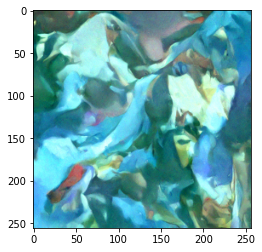

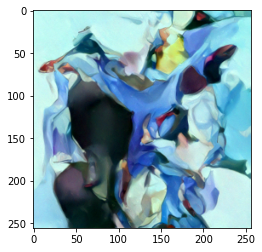

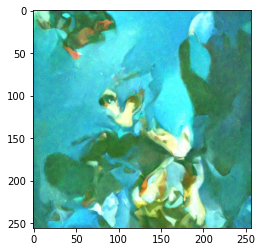

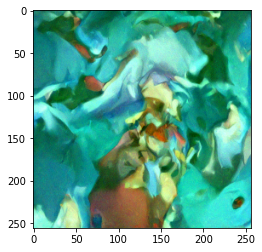

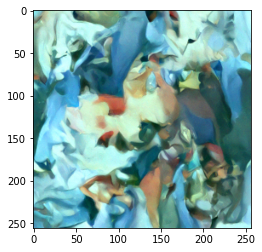

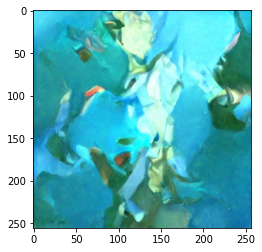

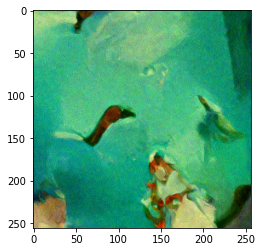

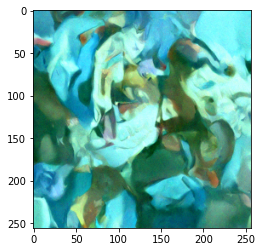

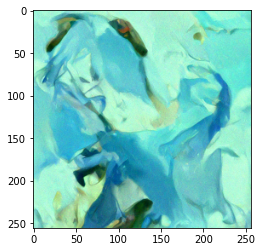

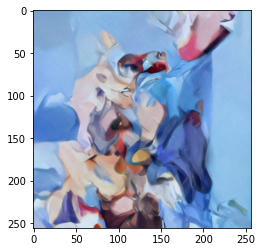

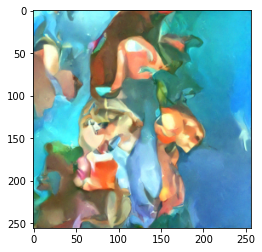

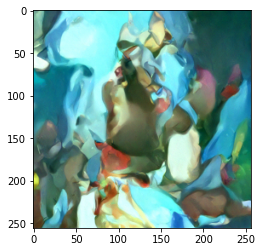

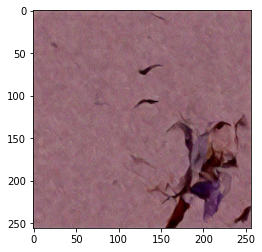

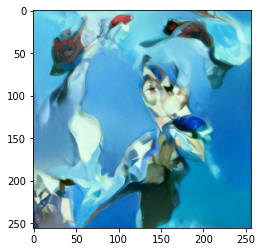

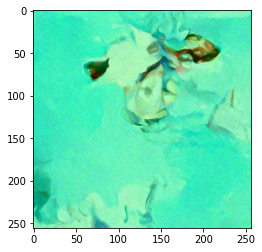

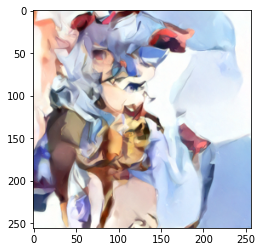

In [43]:
images = "/tmp/openai-2022-08-23-00-51-37-002808/samples_16x256x256x3.npz"

images = np.load(images)

for i in images.f.arr_0:
    plt.imshow(i)
    plt.show()


#plt.imshow(images.f.arr_0[0])
#plt.show()